## IISC CCE course project
### Done by Rahul Seetharaman (rahul.ml.engg@gmail.com)

### Image interpolation results of the Autoencoder architectures

1. Load the MNIST dataset
2. Select a label type and all images that belong to that particular class.
3. For any two random indices, we can observe the interpolation results for three models - Vanilla, Tied Weight and Adversarial

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('/content/drive/MyDrive/dataset', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

In [2]:
indices = []
for i, (data, label) in enumerate(mnist_data):
  if label == 5:
    indices.append(i)

In [3]:
import numpy as np
data = np.array(mnist_data)[indices, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [4]:
data.shape

(360,)

In [5]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [12]:
def interpolate(index1, index2, encoder, decoder):
    x1 = data[index1]
    x2 = data[index2]
    x = torch.stack([x1,x2]).cuda()
    embedding = encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image

    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    if isinstance(encoder, tied_weight.models.EncoderTiedWeights):
      recons = decoder(embedding_values, encoder)
    else:
      recons = decoder(embedding_values)
    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.cpu().detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

In [8]:
import tied_weight
import adversarial
import vanilla

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


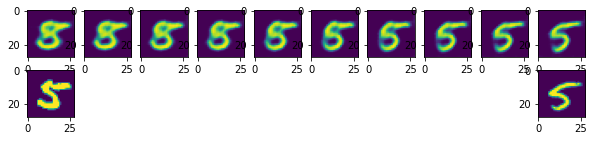

In [28]:
from tied_weight.models import EncoderTiedWeights, DecoderTiedWeights
encoder_tied_weights = EncoderTiedWeights()
decoder_tied_weights = DecoderTiedWeights()
states_tied_weights = torch.load("tied_weight/tied_ae.pt")
encoder_tied_weights.load_state_dict(states_tied_weights["encoder_state"])
decoder_tied_weights.load_state_dict(states_tied_weights["decoder_state"])
encoder_tied_weights = encoder_tied_weights.cuda()
decoder_tied_weights = decoder_tied_weights.cuda()
interpolate(128, 107, encoder_tied_weights, decoder_tied_weights)

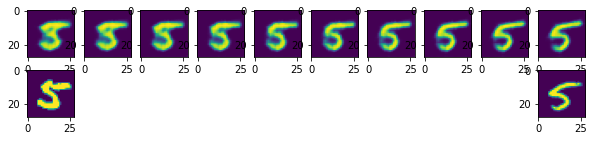

In [29]:
from vanilla.models import Encoder, Decoder
encoder_vanilla = Encoder()
decoder_vanilla = Decoder()
states_vanilla = torch.load("vanilla/vanilla_ae.pt")
encoder_vanilla.load_state_dict(states_vanilla["encoder_state"])
decoder_vanilla.load_state_dict(states_vanilla["decoder_state"])
encoder_vanilla = encoder_vanilla.cuda()
decoder_vanilla = decoder_vanilla.cuda()
interpolate(128, 107, encoder_vanilla, decoder_vanilla)

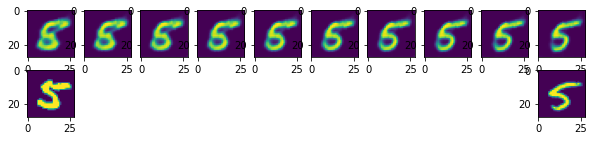

In [31]:
from adversarial.models import EncoderAdv, DecoderAdv
encoder_adv = EncoderAdv()
decoder_adv = DecoderAdv()
states_adv = torch.load("adversarial/adversarial_ae.pt")
encoder_adv.load_state_dict(states_adv["encoder_state"])
decoder_adv.load_state_dict(states_adv["decoder_state"])
encoder_adv = encoder_adv.cuda()
decoder_adv = decoder_adv.cuda()
interpolate(128, 107, encoder_adv, decoder_adv)

### Reconstruction Loss for Autoencoder models - Vanilla, Adversarial and Tied Weights

In [33]:
from vanilla.mnist_utils import MNIST_Util
m = MNIST_Util(data_dir='/content/drive/MyDrive/dataset', batch_size=256)
test_loader = m.get_test_loader()
loss_fn = torch.nn.MSELoss()
device = torch.device('cuda')
with torch.no_grad():
  recon_loss = 0
  for image_batch, _ in test_loader:
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder_vanilla(image_batch)
      # Decode data
      decoded_data = decoder_vanilla(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)
      recon_loss+=loss.detach().cpu().numpy()
print(recon_loss/len(test_loader))

0.017165781604126094


In [34]:
from adversarial.mnist_utils import MNIST_Util
m = MNIST_Util(data_dir='/content/drive/MyDrive/dataset', batch_size=256)
test_loader = m.get_test_loader()
loss_fn = torch.nn.MSELoss()
device = torch.device('cuda')
with torch.no_grad():
  recon_loss = 0
  for image_batch, _ in test_loader:
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder_adv(image_batch)
      # Decode data
      decoded_data = decoder_adv(encoded_data)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)
      recon_loss+=loss.detach().cpu().numpy()
print(recon_loss/len(test_loader))

0.020413604844361544


In [36]:
from tied_weight.mnist_utils import MNIST_Util
m = MNIST_Util(data_dir='/content/drive/MyDrive/dataset', batch_size=256)
test_loader = m.get_test_loader()
loss_fn = torch.nn.MSELoss()
device = torch.device('cuda')
device = torch.device('cuda')
with torch.no_grad():
  recon_loss = 0
  for image_batch, _ in test_loader:
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # Encode data
      encoded_data = encoder_tied_weights(image_batch)
      # Decode data
      decoded_data = decoder_tied_weights(encoded_data, encoder_tied_weights)
      # Evaluate loss
      loss = loss_fn(decoded_data, image_batch)
      recon_loss+=loss.detach().cpu().numpy()
print(recon_loss/len(test_loader))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.016911447001621126


Model Parameters for each Autoencoder model

In [40]:
print(f"Vanilla {states_vanilla['num_parameters']}")
print(f"Adv {states_adv['num_parameters']}")
print(f"Tied {states_tied_weights['num_parameters']}")

Vanilla 88169
Adv 143986
Tied 43987


Average Training Time for each Model (20 mini batches)

In [38]:
import numpy as np
print(f"Vanilla {np.mean(states_vanilla['training_time'])}")
print(f"Adv {np.mean(states_adv['training_time'])}")
print(f"Tied {np.mean(states_tied_weights['training_time'])}")

Vanilla 11.593915247917176
Adv 13.3793394446373
Tied 11.162869441509248


Plot of Training times for each autoencoder model

In [41]:
import matplotlib.pyplot as plt
def plot_me(data, name):
  plt.plot(data)
  plt.title(f'Training Loss - {name}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

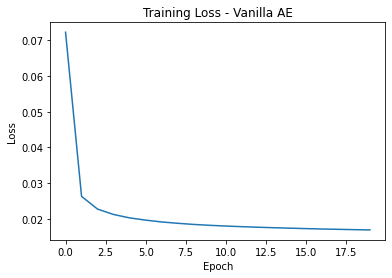

In [42]:
plot_me(states_vanilla['training_loss'], "Vanilla AE")

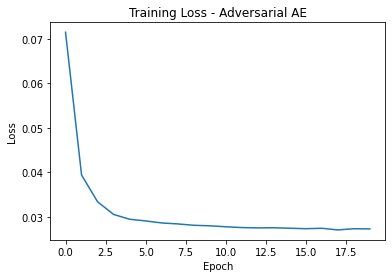

In [43]:
plot_me(states_adv['ae_loss'], "Adversarial AE")

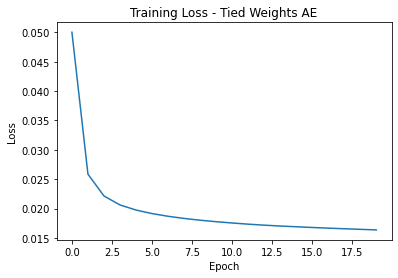

In [44]:
plot_me(states_tied_weights['training_loss'], "Tied Weights AE")

Each model is a torch model with .pt extension. Each file is a serialized python dictionary containing details such as 

1. Model weights (encoder, decoder and discriminator for adversarial AE)
2. Training Loss values (encoder, decoder and discriminator separately)
3. Training time values 
4. Optimizer State
5. Count of Model Parameters 

In [45]:
states_vanilla.keys()

dict_keys(['encoder_state', 'decoder_state', 'training_loss', 'training_time', 'optimizer_state', 'num_parameters'])

In [46]:
states_adv.keys()

dict_keys(['encoder_state', 'decoder_state', 'discriminator_state', 'ae_loss', 'discriminator_loss', 'training_time', 'optimizer_ae', 'optimizer_discriminator', 'num_parameters'])

In [47]:
states_tied_weights.keys()

dict_keys(['encoder_state', 'decoder_state', 'training_loss', 'training_time', 'optimizer_state', 'num_parameters'])